In [1]:
# import sys
# !conda install --yes --prefix {sys.prefix} fbprophet
# !conda install --yes basemap
# !conda install --yes -c conda-forge basemap
# !conda install --yes -c conda-forge basemap-data-hires
import os
import conda

## Start hack to get Basemap to work while Prophet is also installed
## Do not change order of imports!
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap ## this has to come after the file hack above
import fbprophet ## this and the next line have to come after importing Basemap
from fbprophet import Prophet ## in this order
## end hack
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
import matplotlib.patches as mpatches
print('This must be at least version 0.20.0')
print('If it is not, you must upgrade conda and scikit-learn.')
print(sklearn.__version__)
import warnings
warnings.filterwarnings('ignore')
import googlemaps
from datetime import datetime
import local
gmaps = googlemaps.Client(key=local.GOOGLE_MAP_API_KEY)
from IPython.display import display
import pprint
pp = pprint.PrettyPrinter(indent=4)
# from jupyterthemes import jtplot
# jtplot.style()

This must be at least version 0.20.0
If it is not, you must upgrade conda and scikit-learn.
0.20.1


In [2]:
zillow_drop_list = ['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']
pgh_drop_list = ['PROPERTYCITY', 'PROPERTYSTATE', 'MUNICODE', 'DEEDBOOK', 'DEEDPAGE', 'SALEDESC', 'INSTRTYP', 'INSTRTYPDESC', 'PGH_COUNCIL_DISTRICT', 'PGH_WARD', 'PGH_PUBLIC_WORKS_DIVISION', 'PGH_POLICE_ZONE', 'PGH_FIRE_ZONE', 'TRACT', 'RECORDDATE', 'BLOCK_GROUP','SCHOOLCODE', 'SCHOOLDESC', 'MUNICODE','MUNIDESC', 'MUNICIPALITY']
arrests_drop_list = ['_id', 'PK', 'CCR', 'INCIDENTLOCATION', 'INCIDENTZONE', 'INCIDENTTRACT', 'COUNCIL_DISTRICT', 'PUBLIC_WORKS_DIVISION']
valid_codes = ['0', 'U', 'UR', '14', '16', '33', '34', '36', '37', 'BK']

In [3]:
pgh_sales = pd.read_csv('data/pgh_re_2013-2018.csv')
pgh_sales = pgh_sales.loc[pgh_sales.MUNICIPALITY == 'Pittsburgh']
arrests = pd.read_csv('data/arrests_2016.csv')
pgh_city_zip_list = list(pgh_sales.PROPERTYZIP)

In [4]:
zip_income = pd.read_csv('data/zip_income.csv')
demographics = pd.read_csv('data/ACS_14_5YR_S1903_with_ann.csv')
zillow_medians = pd.read_csv('data/Zip_Zhvi_SingleFamilyResidence.csv', engine='python')
zillow_medians.drop(zillow_drop_list, axis=1, inplace=True)
pgh_sales.drop(pgh_drop_list, axis=1, inplace=True)
arrests.drop(arrests_drop_list, axis=1, inplace=True)
zillow_medians.rename(columns={'RegionName': 'zip_code'}, inplace=True)
pgh_time_medians = zillow_medians.loc[zillow_medians.zip_code.isin(pgh_city_zip_list)]

In [5]:
def drop_zeros(x):
    return(str(x).replace('.0', ''))

In [6]:
pgh_sales.PROPERTYHOUSENUM = pgh_sales.PROPERTYHOUSENUM.apply(drop_zeros)
pgh_sales.PROPERTYZIP = pgh_sales.PROPERTYZIP.apply(drop_zeros)

In [7]:
join_list = ['PROPERTYHOUSENUM', 'PROPERTYFRACTION', 
             'PROPERTYADDRESSDIR', 'PROPERTYADDRESSSTREET', 
             'PROPERTYADDRESSSUF', 'PROPERTYADDRESSUNITDESC', 
             'PROPERTYUNITNO']
street_address = pgh_sales[join_list].apply(lambda x: ' '.join(x.astype(str)).strip().replace(' nan', ''), axis=1)
pgh_sales.drop(join_list, axis=1, inplace=True)
pgh_sales = pgh_sales.assign(street_address=street_address)
pgh_sales.rename(str.lower, axis='columns', inplace=True)
pgh_sales.rename(columns={'propertyzip': 'zip_code'}, inplace=True)
# pgh_sales = pgh_sales.loc[~pgh_sales.neighborhood.isna()]
pgh_sales = pgh_sales.loc[pgh_sales.salecode.isin(valid_codes)]
pgh_sales.shape

(20517, 7)

In [8]:
arrests.columns = ['age', 'gender', 'race', 'arresttime', 'location', 'offenses', 'neighborhood', 'lng', 'lat']
arrests = arrests.assign(zip_code=arrests.location.map(lambda x: x[-5:]))
arrests = arrests.loc[arrests.zip_code.isin(pgh_sales.zip_code)]
zip_income.columns = ['zip_code', 'median_income', 'mean_income']
zip_income.zip_code = zip_income.zip_code.astype(str)

In [9]:
demo_keep = {
    'Geography': 'zip_code', 
    'Total; Estimate; Households': 'pop',
    'Total; Estimate; Households - One race-- - White': 'white_pct',
    'Total; Estimate; Households - One race-- - Black or African American': 'black_pct'
            }
demographics = demographics[list(demo_keep.keys())]
demographics.rename(columns=demo_keep, inplace=True)

In [10]:
demographics.zip_code = demographics.zip_code.map(lambda x: x.replace('ZCTA5 ', '').strip())
demographics = pd.merge(demographics, zip_income, on='zip_code')

In [11]:
pgh_city_zip_list = list(map(lambda x: str(x).replace('.0', ''), pgh_city_zip_list))
pgh_city_zip_list
demographics = demographics.loc[demographics.zip_code.isin(pgh_city_zip_list)]
demographics.head()

,zip_code,pop,white_pct,black_pct,median_income,mean_income
74,15106,8736,93.6,5.4,49438,65851
79,15120,8567,80.6,17.6,42157,55258
80,15122,8735,88.4,10.3,47436,62063
98,15201,5999,76.3,19.6,51201,73644
99,15202,9301,90.9,6.7,46541,62455


In [12]:
arrests.set_index('zip_code', inplace=True)
demographics.set_index('zip_code', inplace=True)
arrests = arrests.assign(pop=demographics['pop'])
arrests.reset_index(inplace=True)
demographics.reset_index(inplace=True)

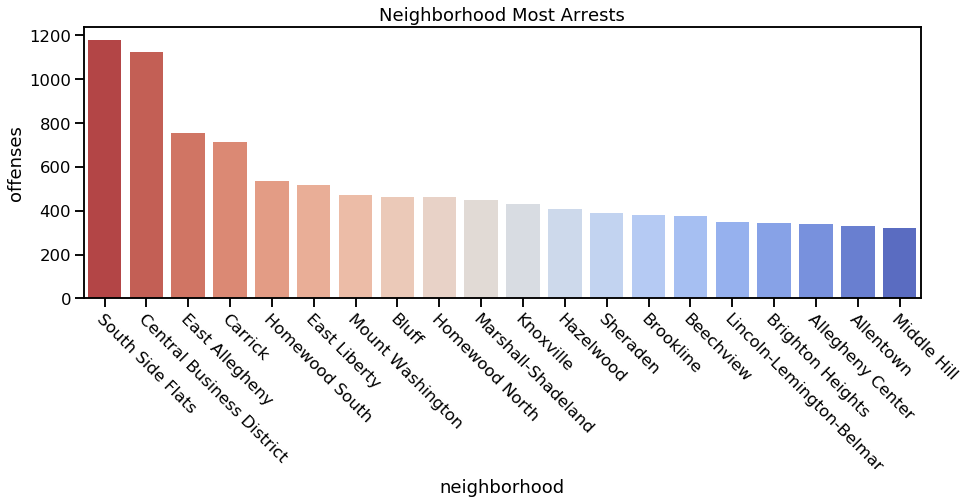

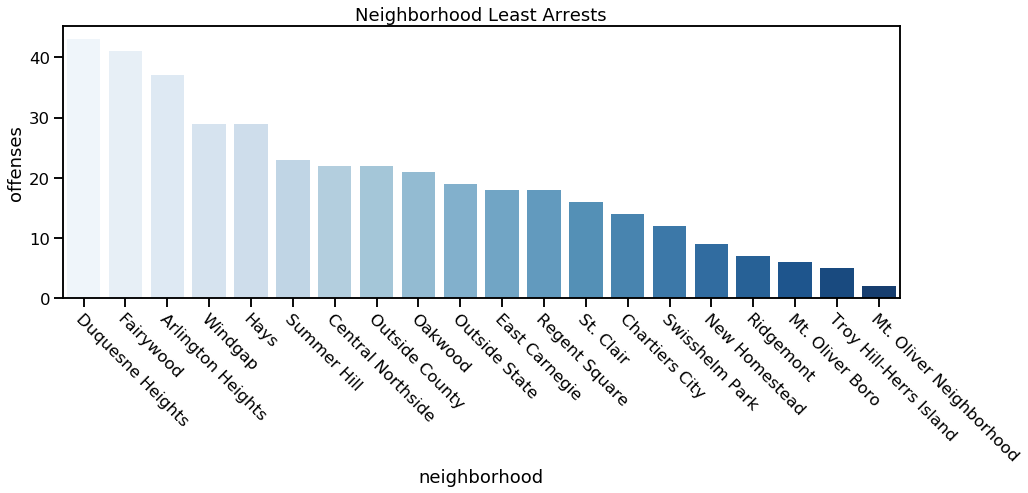

In [13]:
sns.set_context('talk')
arrests_neigh = arrests.groupby(['neighborhood'], as_index=False).agg({'offenses': 'count'})
arrests_neigh.sort_values(by='offenses', ascending=False, inplace=True)
arrests_plot = {
    'Neighborhood Most Arrests': arrests_neigh.head(20),
    'Neighborhood Least Arrests': arrests_neigh.tail(20)
}
colors = ['coolwarm_r', 'Blues']
counter = 0
for name, df in arrests_plot.items():
    plt.figure(figsize=(15, 5))
    sns.barplot(x='neighborhood', y='offenses', data=df, palette=colors[counter])
    plt.xticks(rotation=-45, ha='left',  rotation_mode='anchor')
    plt.title(name)
    counter += 1
plt.show()

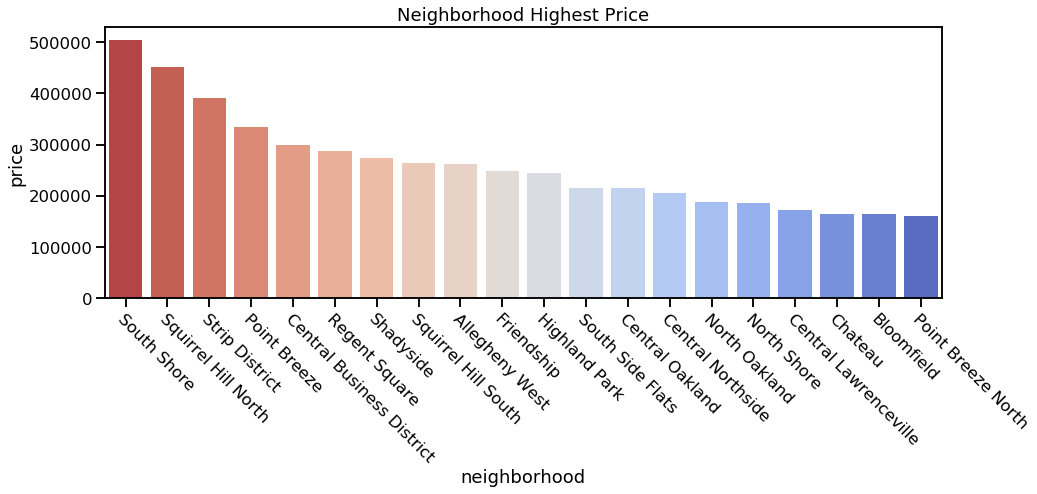

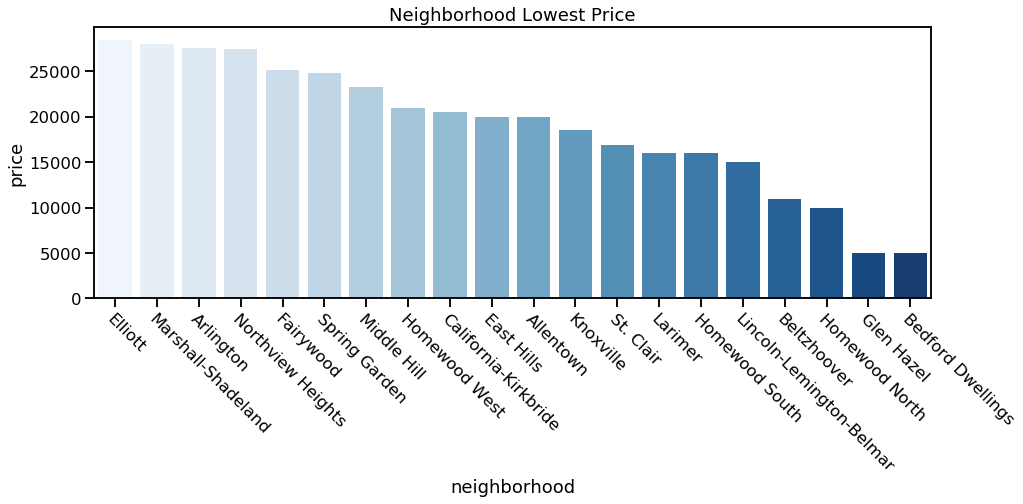

In [14]:
sales_neigh = pgh_sales.groupby(['neighborhood'], as_index=False).agg({'price': 'median'})
sales_neigh.sort_values(by='price', ascending=False, inplace=True)
sales_plot = {
    'Neighborhood Highest Price': sales_neigh.head(20),
    'Neighborhood Lowest Price': sales_neigh.tail(20)
}
colors = ['coolwarm_r', 'Blues']
counter = 0
for name, df in sales_plot.items():
    plt.figure(figsize=(15, 5))
    sns.barplot(x='neighborhood', y='price', data=df, palette=colors[counter])
    plt.xticks(rotation=-45, ha='left',  rotation_mode='anchor')
    plt.title(name)
    counter += 1
plt.show()

In [15]:
city_median = pgh_time_medians.iloc[:, 1:].median()

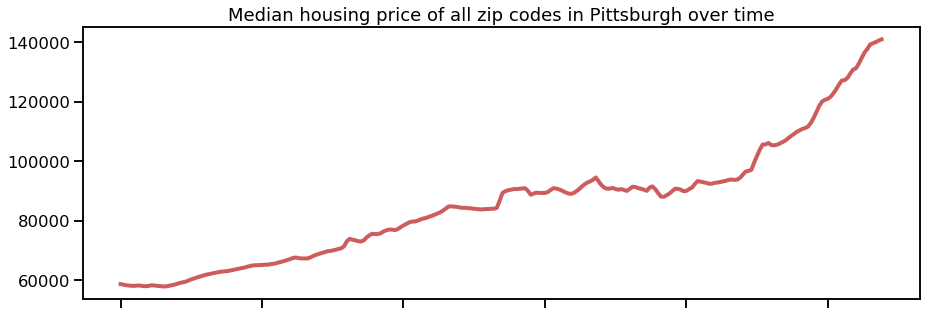

In [16]:
plt.figure(figsize=(15, 5))
city_median.plot(linewidth=4, color='indianred')
plt.title('Median housing price of all zip codes in Pittsburgh over time')
plt.show()

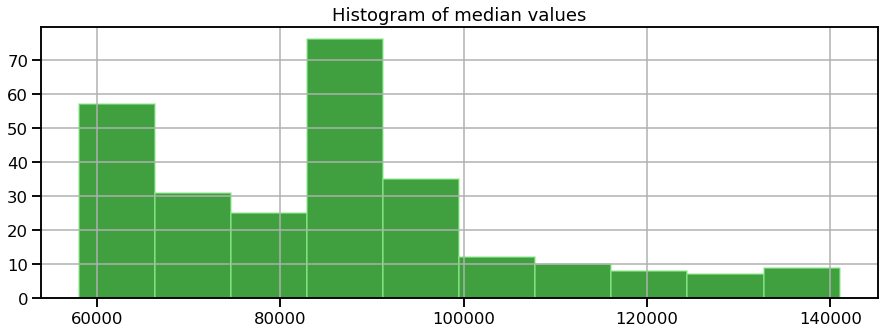

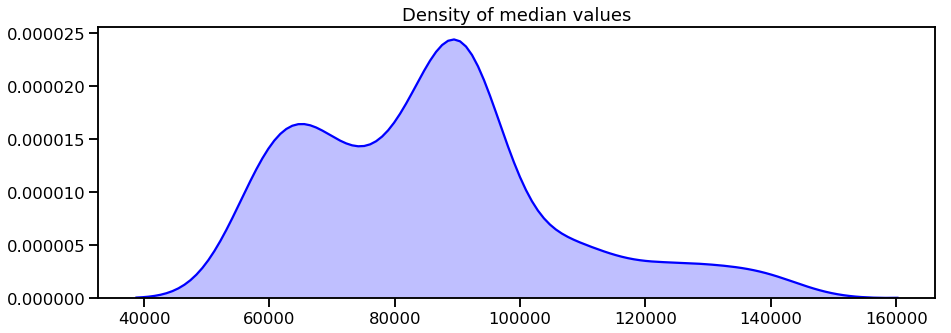

In [17]:
city_median.index = pd.to_datetime(city_median.index)
city_median.hist(figsize=(15, 5), color='g', alpha=.75, ec='lightgreen')
plt.title('Histogram of median values')
plt.show()
plt.figure(figsize=(15, 5))
sns.kdeplot(city_median, color='b', shade=True)
plt.title('Density of median values')
plt.show()

In [18]:
pgh_time_series = pgh_time_medians.copy()
pgh_time_series.rename(columns={'zip_code': 'ds'}, inplace=True)
pgh_time_series = pgh_time_series.set_index('ds').T
pgh_time_series.index = pd.to_datetime(pgh_time_series.index)

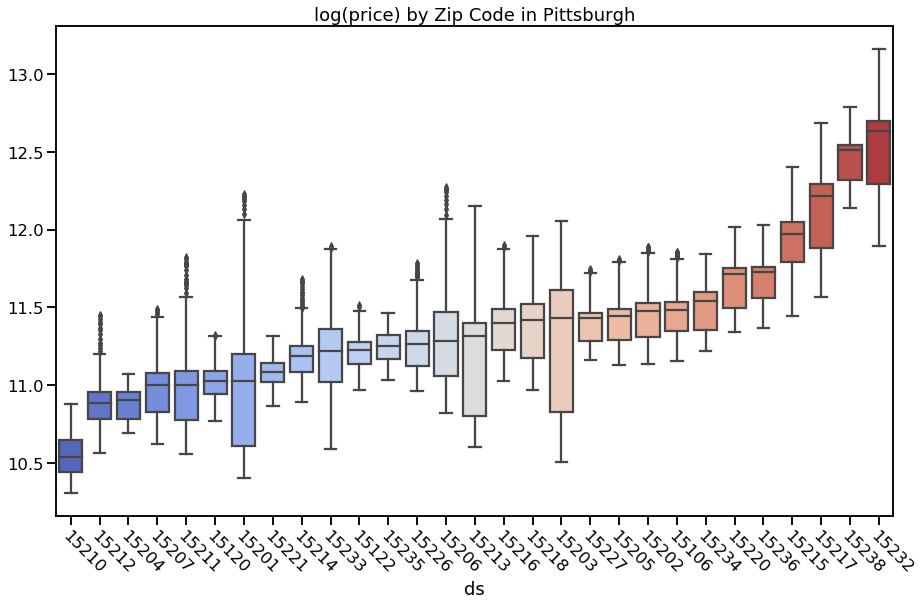

In [19]:
box_set = pgh_time_series.reset_index(drop=True)
plt.figure(figsize=(15, 9))
sns.boxplot(data=np.log(box_set), order=box_set.median().sort_values(ascending=True).index, palette='coolwarm')
plt.xticks(rotation=-45, ha='left', rotation_mode='anchor')
plt.title('log(price) by Zip Code in Pittsburgh')
plt.show()

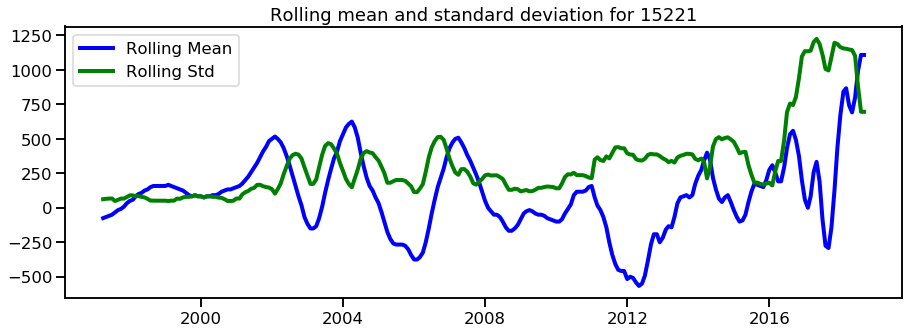

'Test results for zip 15221'

Test Statistic       -4.044854
p-value               0.001193
Critical Value 1%    -3.456155
Critical Value 5%    -2.872897
Critical Value 10%   -2.572822
dtype: float64

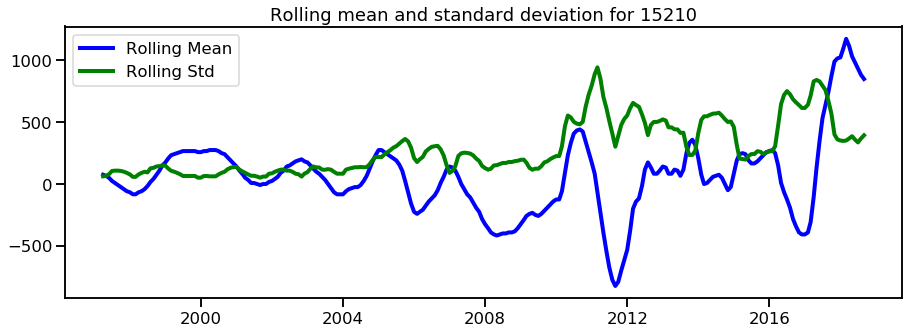

'Test results for zip 15210'

Test Statistic       -4.384561
p-value               0.000316
Critical Value 1%    -3.455461
Critical Value 5%    -2.872593
Critical Value 10%   -2.572660
dtype: float64

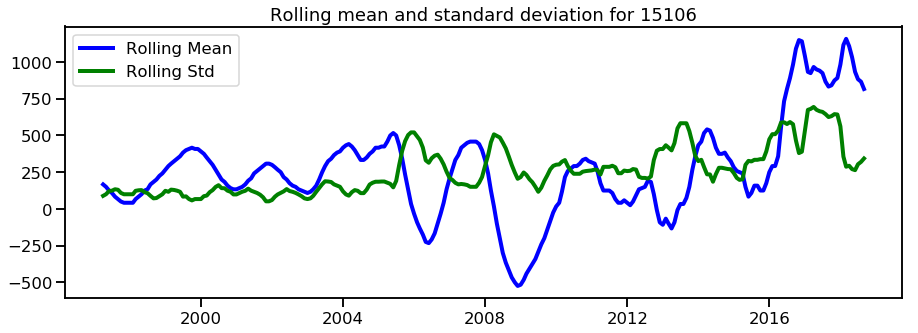

'Test results for zip 15106'

Test Statistic       -3.928295
p-value               0.001836
Critical Value 1%    -3.455175
Critical Value 5%    -2.872468
Critical Value 10%   -2.572593
dtype: float64

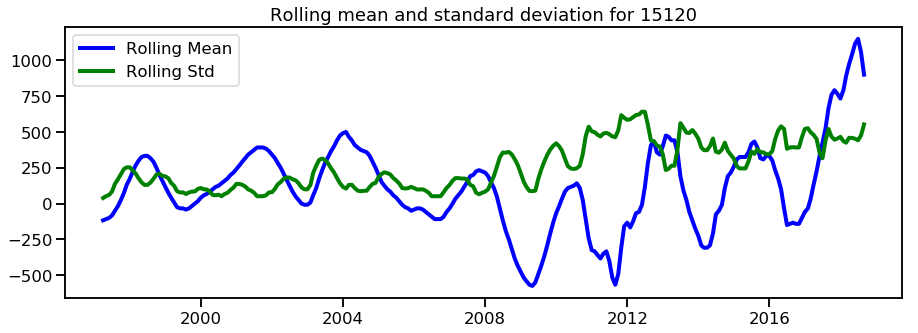

'Test results for zip 15120'

Test Statistic       -5.358437
p-value               0.000004
Critical Value 1%    -3.455953
Critical Value 5%    -2.872809
Critical Value 10%   -2.572775
dtype: float64

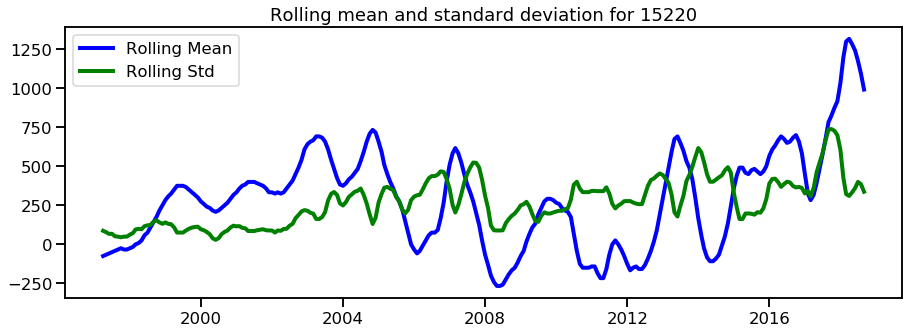

'Test results for zip 15220'

Test Statistic       -4.137556
p-value               0.000839
Critical Value 1%    -3.455270
Critical Value 5%    -2.872509
Critical Value 10%   -2.572615
dtype: float64

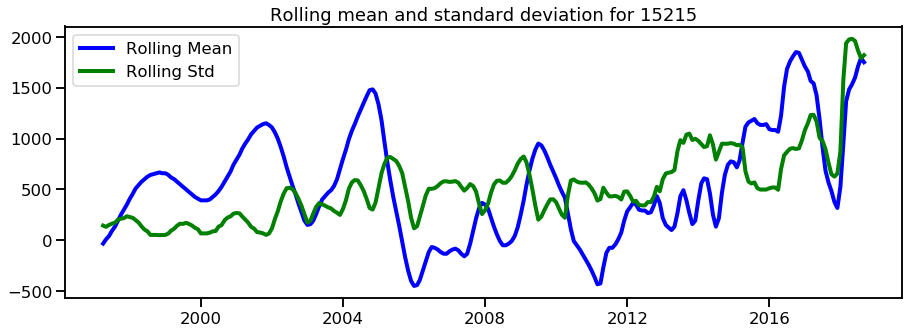

'Test results for zip 15215'

Test Statistic       -5.353022
p-value               0.000004
Critical Value 1%    -3.455270
Critical Value 5%    -2.872509
Critical Value 10%   -2.572615
dtype: float64

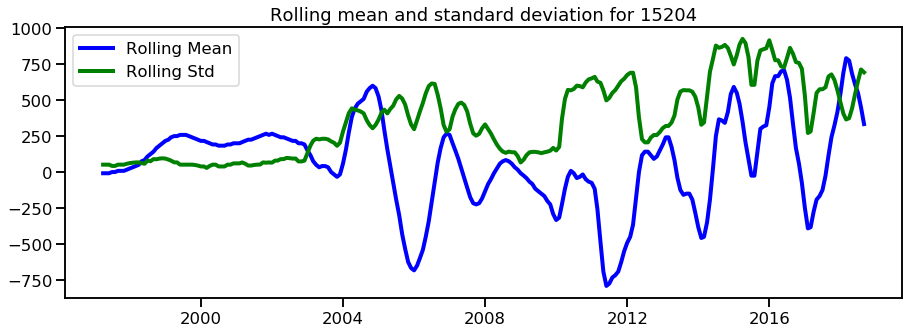

'Test results for zip 15204'

Test Statistic       -4.036288
p-value               0.001232
Critical Value 1%    -3.456155
Critical Value 5%    -2.872897
Critical Value 10%   -2.572822
dtype: float64

In [20]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(name: str, timeseries: pd.Series): 
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value
    return(dfoutput)

def plot_time_series(name, time_series):
    plt.figure(figsize=(15, 5))
    rolmean = time_series.rolling(12).mean()
    rolstd = time_series.rolling(12).std()
    mean = plt.plot(rolmean, color='b', label='Rolling Mean', linewidth=4)
    std = plt.plot(rolstd, color='g', label='Rolling Std', linewidth=4)
    plt.legend(loc='best')
    plt.title(f'Rolling mean and standard deviation for {name}')
    plt.show()

sta_series = {}
series_orig = {}
for series in pgh_time_series.iteritems():
    temp_series = series[1].diff()
    temp_series.dropna(inplace=True)
    name = series[0]
    results = test_stationarity(name, temp_series)
    if results[0] < results[2] and results[1] < .05:
        series_orig[name] = series[1]
        sta_series[name] = temp_series
        plot_time_series(name, temp_series)
        display(f'Test results for zip {name}', results)

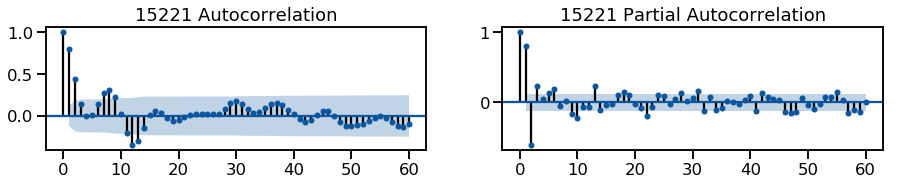

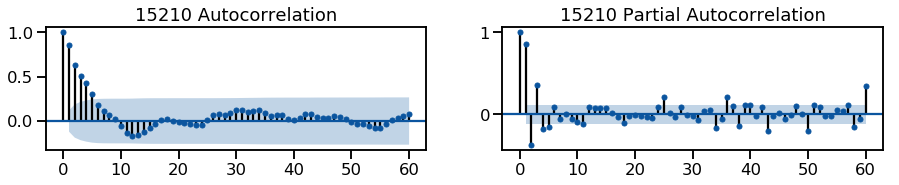

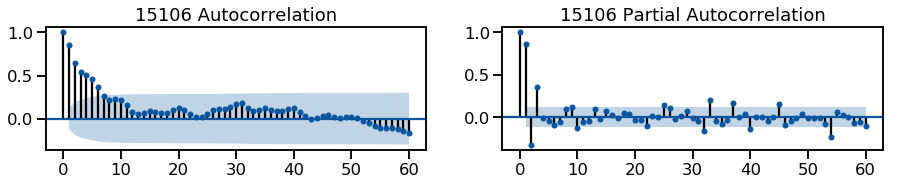

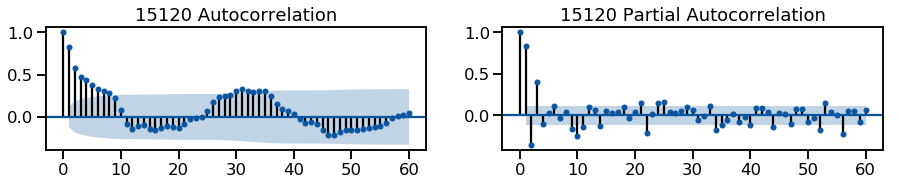

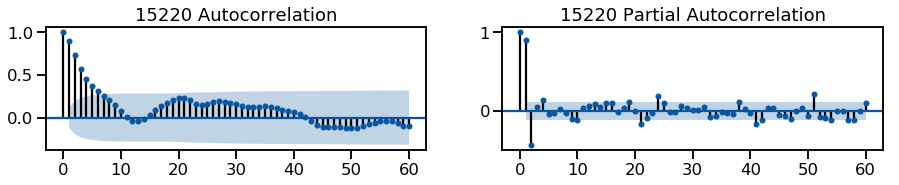

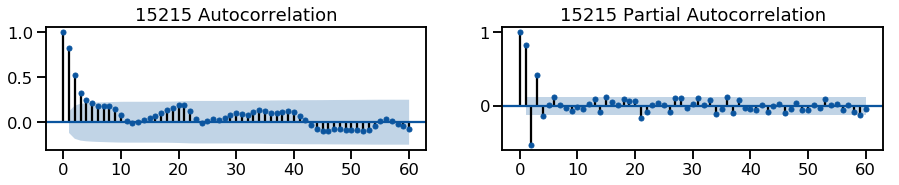

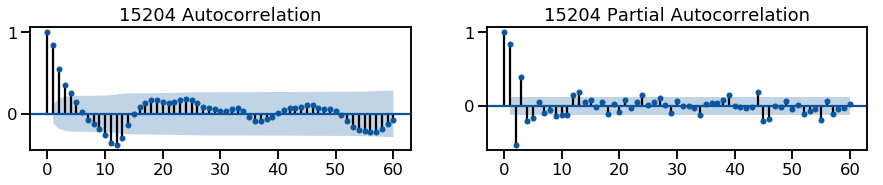

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set_context('talk')
sns.set_palette('Blues_r')
for name, df in sta_series.items():
    plt.figure(figsize=(15, 5))
    plt.subplot(221); plot_acf(df, lags=60, ax=plt.gca(), title=f'{name} Autocorrelation')
    plt.subplot(222); plot_pacf(df,  lags=60, ax=plt.gca(), title=f'{name} Partial Autocorrelation')


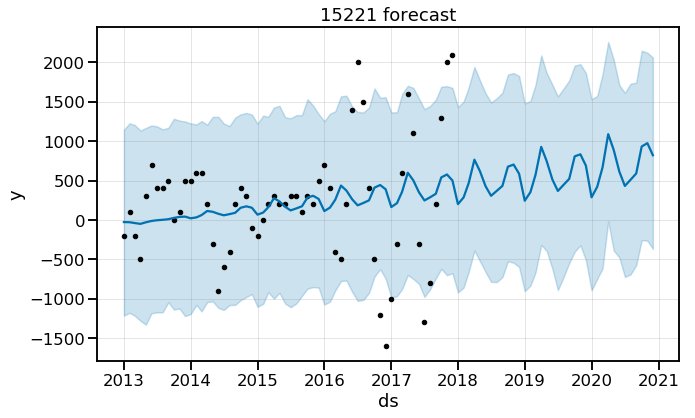

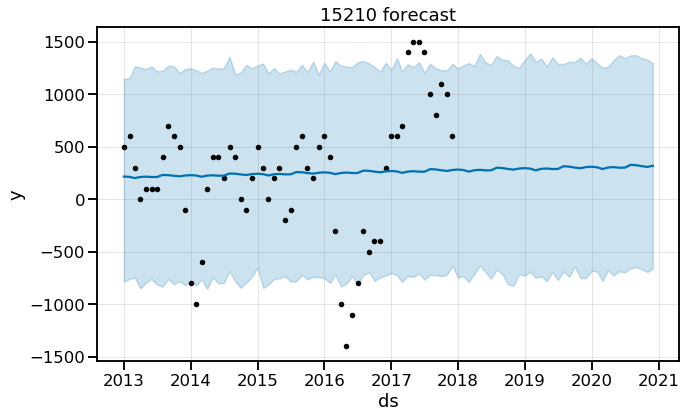

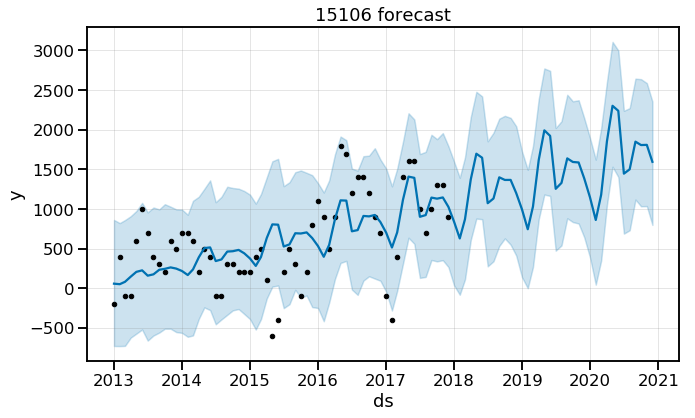

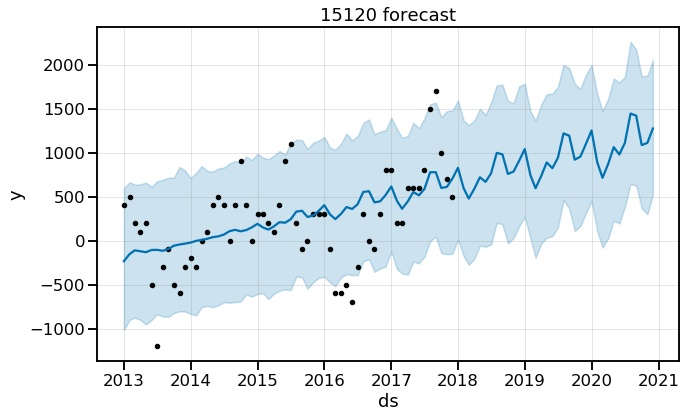

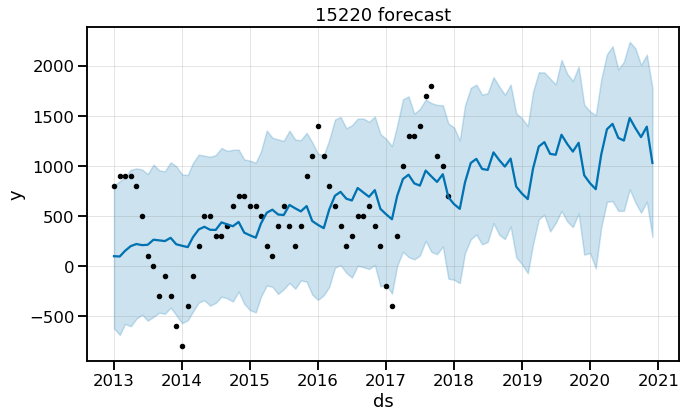

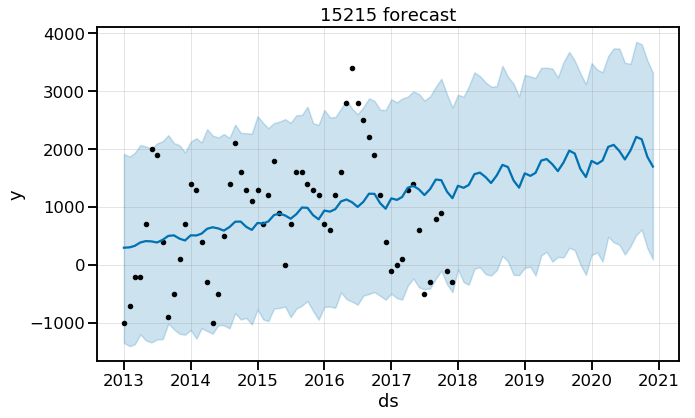

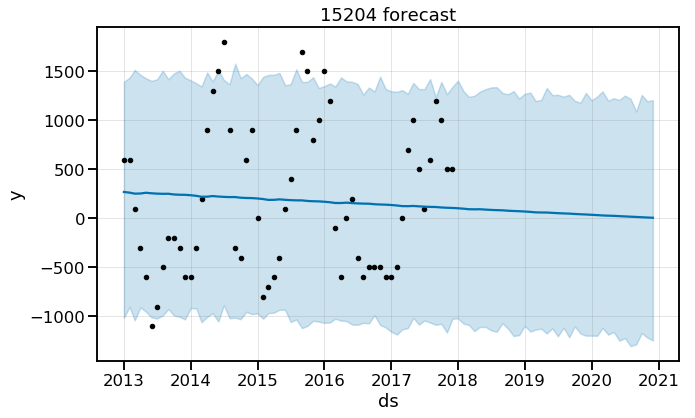

In [22]:
forecasts = {}
for name, df in sta_series.items():
    name = f'{name} forecast'
    temp = pd.DataFrame(df['2013':'2017'])
    temp.reset_index(inplace=True)
    temp.columns = ['ds', 'y']
    prophet_model = Prophet(
        interval_width=0.9, 
        weekly_seasonality=False, 
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )
    prophet_model.fit(temp)
    future = prophet_model.make_future_dataframe(periods=12*3, freq='M')
    forecast = prophet_model.predict(future)
    forecasts[name] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    prophet_model.plot(forecast)
    plt.title(name)
    plt.show()

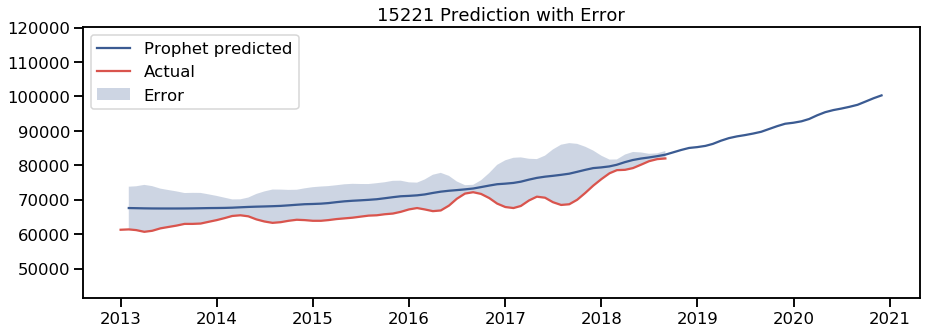

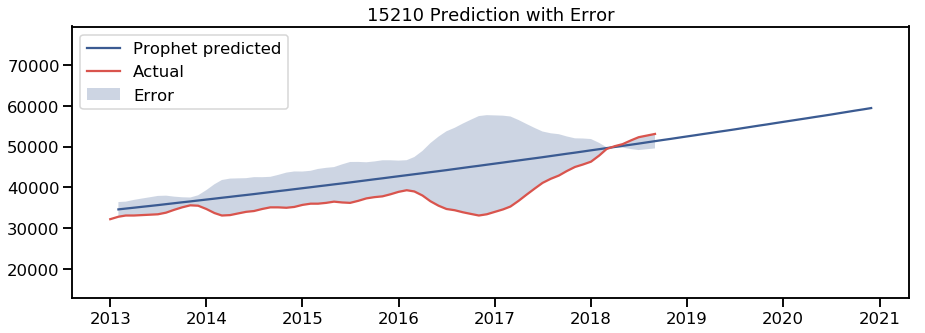

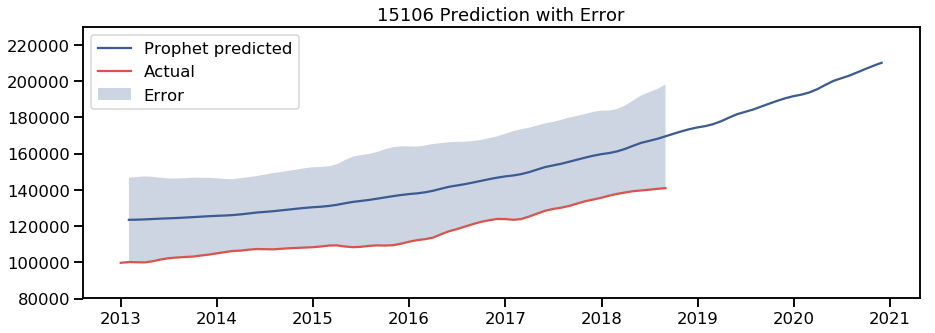

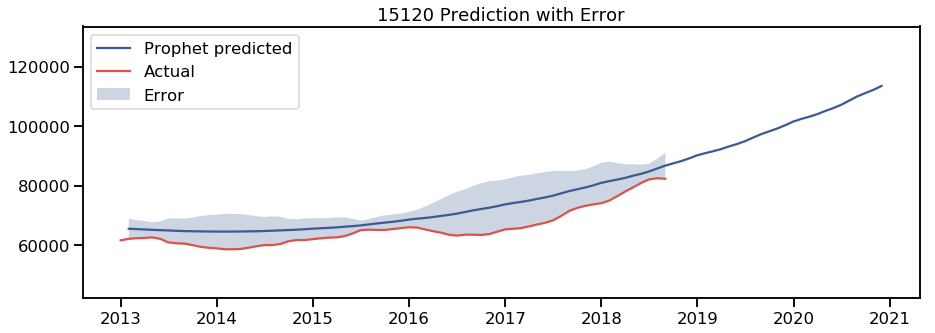

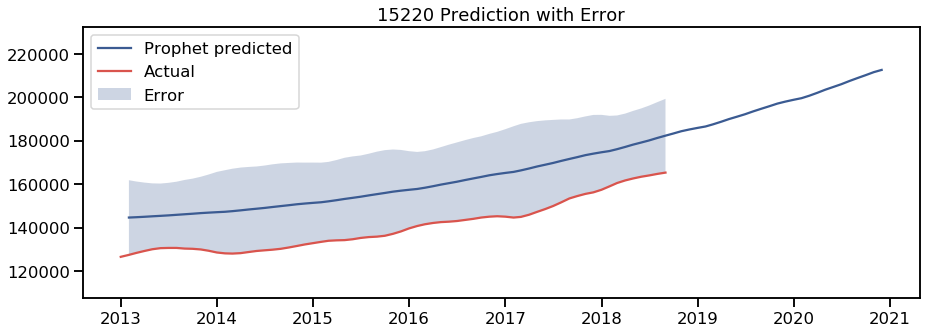

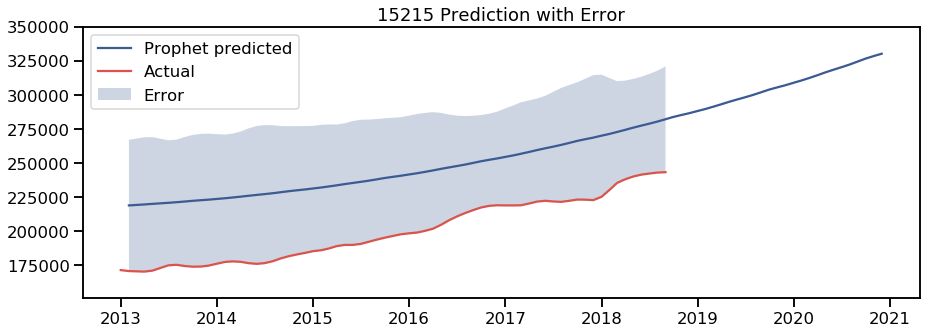

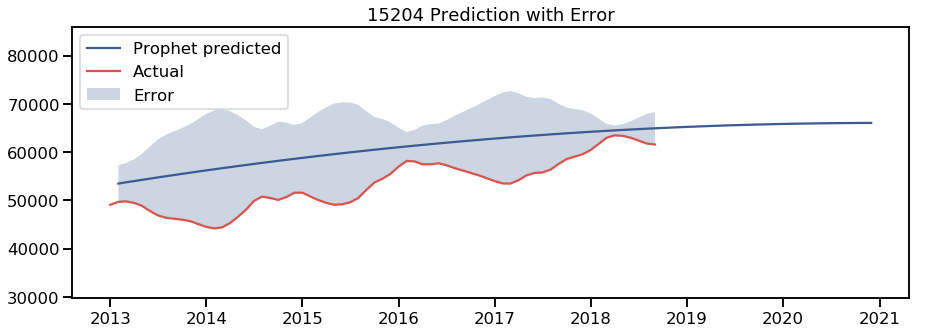

In [23]:
colors = ['denim blue', 'pale red']
sns.set_palette(sns.xkcd_palette(colors))
deltas = {}
for name, df in series_orig.items():
    temp_2018 = df.iloc[-20:]

    forecast = forecasts[f'{name} forecast']
    _pred = forecast.loc[forecast.ds > '2013']
    _pred = _pred.loc[_pred.ds < '2021']
    prophet_predict = np.r_[
        temp_2018.iloc[0],
        _pred.yhat.iloc[1:]
    ].cumsum()
    error = np.abs(df['2013-02-01':] - prophet_predict[:68])
    delta = prophet_predict[-1] - temp_2018[-1]
    deltas[name] = {
        'delta': delta,
        'orig': temp_2018[-1],
        'pred': prophet_predict[-1],
        'error': np.median(error),
        'delta_minus_error': delta - np.median(error),
        'median_price_2018': temp_2018.median()
    }
    plt.figure(figsize=(15, 5))
    plt.plot(_pred.ds, prophet_predict, label='Prophet predicted')
    plt.plot(df['2013':], label='Actual')
    x = pd.to_datetime(df['2013-02-01':].index)
    y = prophet_predict[:68]
    plt.fill_between(
        x, 
        y+error,
        y-error, 
        alpha=0.25,
        label='Error'
    )
    plt.title(f'{name} Prediction with Error')
    plt.legend(loc='upper left')
    plt.ylim(bottom=(y[0]-error[0])-20000, top=np.max(prophet_predict)+20000)

In [24]:
investment_zips = pd.DataFrame(deltas).T
investment_zips.assign(
    pct_delta=lambda x: (x['delta_minus_error'] / x['median_price_2018']) * 100
).sort_values(by='pct_delta', ascending=False)

,delta,delta_minus_error,error,median_price_2018,orig,pred,pct_delta
15120,31243.340393,26554.241412,4689.098981,73450.0,82300.0,113543.340393,36.152813
15106,69165.113448,45511.812681,23653.300767,134250.0,141000.0,210165.113448,33.900792
15215,86966.861417,42621.480718,44345.380698,223050.0,243200.0,330166.861417,19.108487
15221,18304.038383,13673.907775,4630.130609,73050.0,82000.0,100304.038383,18.718560
15220,47304.587519,28862.208465,18442.379054,155850.0,165300.0,212604.587519,18.519223
15210,6346.515477,2148.051741,4198.463736,45300.0,53100.0,59446.515477,4.741836
15204,4474.241954,-2790.379584,7264.621538,59350.0,61600.0,66074.241954,-4.701566


In [25]:
import re
pgh_sales_demo = pgh_sales.merge(demographics)
zip_median = pgh_sales_demo.groupby('zip_code', as_index=False).agg({'price': 'median'})
zip_median.rename(columns={'price': 'zip_median_price'}, inplace=True)
pgh_sales_demo = pgh_sales_demo.merge(zip_median)
arrest_counts = arrests.groupby('zip_code', as_index=False).agg({'offenses': 'count'})
arrest_counts.rename(columns={'offenses': 'total_arrests'}, inplace=True)
whole_enchilada = pgh_sales_demo.merge(arrest_counts)
nums = ['white_pct', 'black_pct', 'median_income']
for num in nums: whole_enchilada[num] = pd.to_numeric(whole_enchilada[num]);
whole_enchilada['saledate'] = pd.to_datetime(whole_enchilada['saledate'])
whole_enchilada.street_address = whole_enchilada.street_address.apply(lambda x: re.sub(' +', ' ', x))
whole_enchilada.dropna(inplace=True)
whole_enchilada.drop(whole_enchilada.loc[whole_enchilada.price == whole_enchilada.price.max()].index, inplace=True)

In [26]:
def impute_median(x):
    if x['price'] < 1000:
        x['price'] = x['zip_median_price']
    return x
whole_enchilada = whole_enchilada.apply(impute_median, axis=1)

In [27]:
#!pip install python-zillow
import zillow
from zillow import ZillowError
from local import *
zapi_key = ZILLOW_API_KEY
zapi = zillow.ValuationApi()

In [183]:
"""
These next three cells have to be run everyday because I have a Zillow api limit of 5000 per day.
This one reads in all the calls that have already been made.
The next one makes calls to Zillow that have not already been made.
And the next cell after that persists all this data to csvs.
And then the next day we start over again with this cell.
"""

import glob
pwd = os.getcwd()
encyclopedia = {
    'good_calls': {
        'path': f'{pwd}/data/good_calls/'
    },
    'bad_calls': {
        'path': f'{pwd}/data/bad_calls/'
    }
}
already_called = []
for name, dictionary in encyclopedia.items():
    path = dictionary['path']
    if os.path.isdir(path):
        for file in glob.glob(f'{path}/*'):
            df = pd.read_csv(file, index_col=0)
            try:
                dictionary['frame'] = pd.concat([dictionary['frame'], df])
            except KeyError:
                dictionary['frame'] = df
            called = df.parid.tolist()
            if len(called):
                already_called.extend(called)

In [184]:
"""
The call to Zillow.
"""
from datetime import datetime
import json
year = datetime.now().year + 1 # we're adding one year because it's Dec 2018
api_limit = 4500 # <- frowny face emoji
count_down = api_limit
house_details = {}
bad_calls = {}
for row in whole_enchilada.iterrows():
    id = row[1].parid
    if id in already_called:
        continue
    count_down -= 1
    try:
        house = zapi.GetDeepSearchResults(zapi_key, row[1].street_address, row[1].zip_code)
    except ZillowError as e:
        print(f'. {api_limit - count_down}')
        bad_calls[id] = f'{row[1].street_address}, {row[1].zip_code}'
        continue
    ext_data = house.get_dict()['extended_data']
    address = house.get_dict()['full_address']
    if ext_data['year_built'] is not None:
        age = year - int(ext_data['year_built'])
    house_details[id] = {
        'use_code': ext_data['year_built'],
        'year_built': ext_data['year_built'],
        'age': age,
        'lot_size': ext_data['lot_size_sqft'],
        'sqft': ext_data['finished_sqft'],
        'baths': ext_data['bathrooms'],
        'beds': ext_data['bedrooms'],
        'lng': address['longitude'],
        'lat': address['longitude']
    }
    if count_down % 200 == 0:
        display(house_details[id])
    if count_down <= 1:
        break
print('ding fries are done')
print(f'{api_limit - count_down} calls made')

. 38
. 42
. 43
. 60
. 72
. 79
. 86


{'use_code': '1919',
 'year_built': '1919',
 'age': 100,
 'lot_size': '2180',
 'sqft': '1836',
 'baths': '1.0',
 'beds': '3',
 'lng': '-79.990244',
 'lat': '-79.990244'}

. 118
. 132
. 154
. 182
. 200
. 213
. 216
. 223
. 226
. 250
. 253
. 258
. 259
. 262
. 277
. 288


{'use_code': '1938',
 'year_built': '1938',
 'age': 81,
 'lot_size': '5000',
 'sqft': '1927',
 'baths': '2.0',
 'beds': '4',
 'lng': '-80.030689',
 'lat': '-80.030689'}

. 336
. 346
. 376
. 389
. 395
. 423
. 426
. 448
. 468
. 480
. 493


{'use_code': '1927',
 'year_built': '1927',
 'age': 92,
 'lot_size': '4606',
 'sqft': '1849',
 'baths': '2.0',
 'beds': '4',
 'lng': '-80.068421',
 'lat': '-80.068421'}

. 512
. 527
. 544
. 557
. 607
. 611
. 613
. 616
. 627
. 639
. 658
. 659
. 662
. 677


{'use_code': '1905',
 'year_built': '1905',
 'age': 114,
 'lot_size': '3000',
 'sqft': '1555',
 'baths': '1.0',
 'beds': '3',
 'lng': '-80.054993',
 'lat': '-80.054993'}

. 705
. 730
. 734
. 735
. 768
. 786
. 798
. 812
. 830
. 842
. 844
. 860
. 871


{'use_code': '1945',
 'year_built': '1945',
 'age': 74,
 'lot_size': '2340',
 'sqft': '1220',
 'baths': '1.0',
 'beds': '3',
 'lng': '-80.038765',
 'lat': '-80.038765'}

. 904
. 913
. 921
. 957
. 990
. 1004
. 1019
. 1027
. 1028
. 1034
. 1036
. 1048
. 1049
. 1050
. 1052
. 1059
. 1082
. 1089
. 1091
. 1092


{'use_code': '1950',
 'year_built': '1950',
 'age': 69,
 'lot_size': '2612',
 'sqft': '1344',
 'baths': '1.5',
 'beds': '3',
 'lng': '-80.041092',
 'lat': '-80.041092'}

. 1112
. 1117
. 1123
. 1125
. 1136
. 1169
. 1180
. 1186
. 1194
. 1197
. 1200
. 1221
. 1224
. 1229
. 1264
. 1270
. 1272
. 1282
. 1287
. 1295
. 1299


{'use_code': '1952',
 'year_built': '1952',
 'age': 67,
 'lot_size': '9938',
 'sqft': '912',
 'baths': '1.5',
 'beds': '3',
 'lng': '-80.046691',
 'lat': '-80.046691'}

. 1334
. 1350
. 1355
. 1358
. 1369
. 1374
. 1407
. 1416
. 1443
. 1480
. 1499


{'use_code': '1900',
 'year_built': '1900',
 'age': 119,
 'lot_size': '1651',
 'sqft': '1444',
 'baths': '1.0',
 'beds': '3',
 'lng': '-79.942657',
 'lat': '-79.942657'}

. 1517
. 1539
. 1540
. 1547
. 1566
. 1568
. 1569
. 1579
. 1582
. 1583
. 1590
. 1603
. 1607
. 1614
. 1626
. 1640
. 1657
. 1658
. 1669
. 1679
. 1680
. 1700
. 1702
. 1730
. 1734
. 1742
. 1753
. 1781
. 1782
. 1786
. 1797
. 1824
. 1835
. 1888
. 1900
. 1931
. 1999
. 2000
. 2012
. 2018
. 2031
. 2032
. 2074
. 2081


{'use_code': '1916',
 'year_built': '1916',
 'age': 103,
 'lot_size': '7200',
 'sqft': '1583',
 'baths': '1.5',
 'beds': '3',
 'lng': '-79.906174',
 'lat': '-79.906174'}

. 2157
. 2165
. 2171
. 2184
. 2202
. 2236
. 2238
. 2241
. 2285
. 2293


{'use_code': '1900',
 'year_built': '1900',
 'age': 119,
 'lot_size': '828',
 'sqft': '1200',
 'baths': '1.5',
 'beds': '3',
 'lng': '-79.980277',
 'lat': '-79.980277'}

. 2318
. 2341
. 2343
. 2355
. 2370
. 2382
. 2397
. 2398
. 2403
. 2411
. 2432
. 2453
. 2454
. 2464
. 2476
. 2481
. 2484


{'use_code': None,
 'year_built': None,
 'age': 119,
 'lot_size': '1872',
 'sqft': None,
 'baths': None,
 'beds': '0',
 'lng': '-79.966952',
 'lat': '-79.966952'}

. 2504
. 2508
. 2514
. 2524
. 2536
. 2550
. 2561
. 2562
. 2590
. 2628
. 2631
. 2633
. 2647
. 2656
. 2657
. 2672
. 2673
. 2680
. 2697
. 2698
. 2700
. 2707
. 2762
. 2779
. 2800
. 2819
. 2863
. 2888


{'use_code': '1998',
 'year_built': '1998',
 'age': 21,
 'lot_size': '784',
 'sqft': '1024',
 'baths': '2.0',
 'beds': '2',
 'lng': '-79.982143',
 'lat': '-79.982143'}

. 2908
. 2913
. 2919
. 2933
. 2971
. 2978
. 2979
. 3006
. 3015
. 3016
. 3026
. 3042
. 3050
. 3060
. 3084
. 3098


{'use_code': '1890',
 'year_built': '1890',
 'age': 129,
 'lot_size': '1878',
 'sqft': '2000',
 'baths': '2.5',
 'beds': '2',
 'lng': '-79.966779',
 'lat': '-79.966779'}

. 3108
. 3110
. 3112
. 3185
. 3191
. 3215
. 3228
. 3244
. 3251
. 3254
. 3255
. 3258
. 3259
. 3263
. 3267
. 3272
. 3274
. 3283
. 3297


{'use_code': '1900',
 'year_built': '1900',
 'age': 119,
 'lot_size': '5580',
 'sqft': '2760',
 'baths': '2.5',
 'beds': '3',
 'lng': '-79.966381',
 'lat': '-79.966381'}

. 3302
. 3303
. 3305
. 3308
. 3309
. 3313
. 3315
. 3321
. 3326
. 3327
. 3331
. 3334
. 3335
. 3336
. 3338
. 3339
. 3340
. 3342
. 3345
. 3349
. 3350
. 3352
. 3364
. 3367
. 3371
. 3374
. 3377
. 3380
. 3385
. 3389
. 3394
. 3397
. 3400
. 3406
. 3411
. 3413
. 3415
. 3416
. 3418
. 3419
. 3420
. 3422
. 3430
. 3431
. 3433
. 3434
. 3435
. 3436
. 3438
. 3446
. 3453
. 3456
. 3458
. 3465
. 3467
. 3470
. 3476
. 3489
. 3492


{'use_code': '1910',
 'year_built': '1910',
 'age': 109,
 'lot_size': '2000',
 'sqft': '1725',
 'baths': '1.5',
 'beds': '3',
 'lng': '-79.970705',
 'lat': '-79.970705'}

. 3505
. 3509
. 3514
. 3518
. 3525
. 3527
. 3528
. 3537
. 3540
. 3548
. 3549
. 3552
. 3557
. 3558
. 3561
. 3563
. 3568
. 3575
. 3581
. 3585
. 3588
. 3592
. 3595
. 3597
. 3604
. 3609
. 3613
. 3614
. 3628
. 3637
. 3638
. 3648
. 3651
. 3653
. 3656
. 3657
. 3658
. 3659
. 3662
. 3664
. 3669
. 3672
. 3675
. 3677
. 3684
. 3686
. 3696
. 3700
. 3740
. 3743
. 3763
. 3772
. 3778
. 3779
. 3789
. 3792
. 3801
. 3849


{'use_code': '1940',
 'year_built': '1940',
 'age': 79,
 'lot_size': '4965',
 'sqft': '1328',
 'baths': '2.0',
 'beds': '3',
 'lng': '-79.992207',
 'lat': '-79.992207'}

. 3927
. 3947
. 3951
. 3972
. 3974
. 3978
. 3989
. 4013
. 4018
. 4026
. 4048
. 4070
. 4071
. 4072
. 4097
. 4099


{'use_code': '1900',
 'year_built': '1900',
 'age': 119,
 'lot_size': '5750',
 'sqft': '900',
 'baths': '2.0',
 'beds': '3',
 'lng': '-79.967909',
 'lat': '-79.967909'}

. 4102
. 4103
. 4117
. 4124
. 4126
. 4132
. 4162
. 4163
. 4177
. 4213
. 4223
. 4229
. 4232
. 4257
. 4260
. 4265


{'use_code': '1900',
 'year_built': '1900',
 'age': 119,
 'lot_size': '4250',
 'sqft': '1920',
 'baths': '1.0',
 'beds': '3',
 'lng': '-80.007849',
 'lat': '-80.007849'}

. 4310
. 4326
. 4330
. 4331
. 4342
. 4351
. 4355
. 4356
. 4395
. 4407
. 4424
. 4434
. 4444
. 4455
. 4479
ding fries are done
4499 calls made


In [189]:
now = datetime.now()
right_now =  f'{now.year}_{now.month}_{now.day}_{now.hour}_{now.minute}'
bad_calls_dir = f'{pwd}/data/bad_calls/'
good_calls_dir = f'{pwd}/data/good_calls/'
for path in [bad_calls_dir, good_calls_dir]:
    if not os.path.isdir(path):
        os.makedirs(path)
bad_calls_today = pd.DataFrame(
    {
        'parid': [key for key in bad_calls.keys()], 
        'address': [add for add in bad_calls.values()]
    }
)
bad_calls_today.to_csv(f'data/bad_calls/{right_now}.csv')
good_calls = pd.DataFrame(house_details).T.reset_index().rename(columns={'index': 'parid'})
good_calls.to_csv(f'data/good_calls/{right_now}.csv')

In [190]:
todo_bueno = pd.concat([good_calls, encyclopedia['good_calls']['frame']])
display('Good calls made to Zillow', todo_bueno.shape[0])
display('All previous data', whole_enchilada.shape[0])

'Good calls made to Zillow'

14844

'All previous data'

20472

In [195]:
final_set = todo_bueno.merge(whole_enchilada, on='parid', how='left')
final_set.drop(['use_code', 'salecode'], axis=1, inplace=True)
aggregate_attributes = ['zip_median_price', 'total_arrests', 'mean_income', 
                        'median_income', 'black_pct', 'white_pct', 'pop']
cat_attributes = ['street_address', 'neighborhood', 'zip_code', 'year_built']
ind_num_attributes = ['age', 'baths', 'beds', 'lot_size', 'sqft', 'price']
all_num_attributes = aggregate_attributes + ind_num_attributes
final_set[all_num_attributes] = final_set[all_num_attributes].astype('float64')
final_set.drop(final_set.loc[final_set.price == final_set.price.max()].index, inplace=True)

In [196]:
final_set.loc[final_set.lot_size >= 200000, ['lot_size', 'neighborhood']]

,lot_size,neighborhood
27,1089000.0,Troy Hill
320,1089000.0,Sheraden
343,2178000.0,Crafton Heights
802,2178000.0,Sheraden
868,1742400.0,Ridgemont
1903,827640.0,Hazelwood
2037,522720.0,South Side Flats
2351,871200.0,South Side Flats
2813,805860.0,South Side Flats
2898,696960.0,South Side Flats


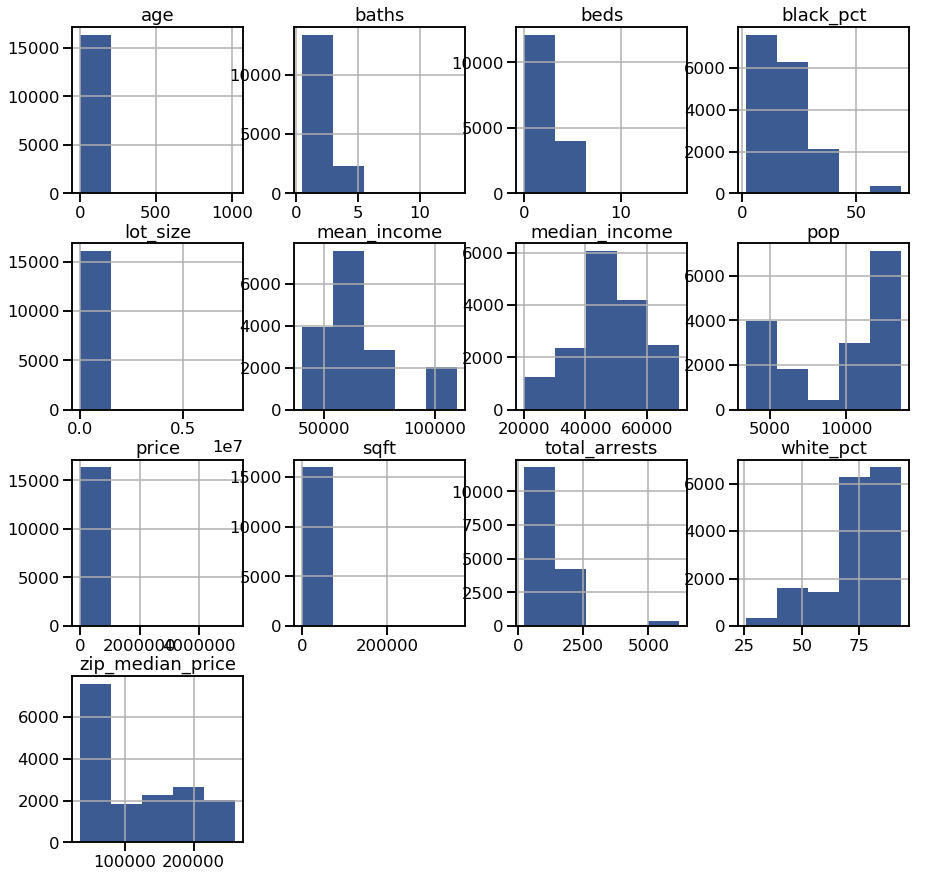

In [193]:
final_set.hist(bins=5, figsize=(15, 15))
plt.show()

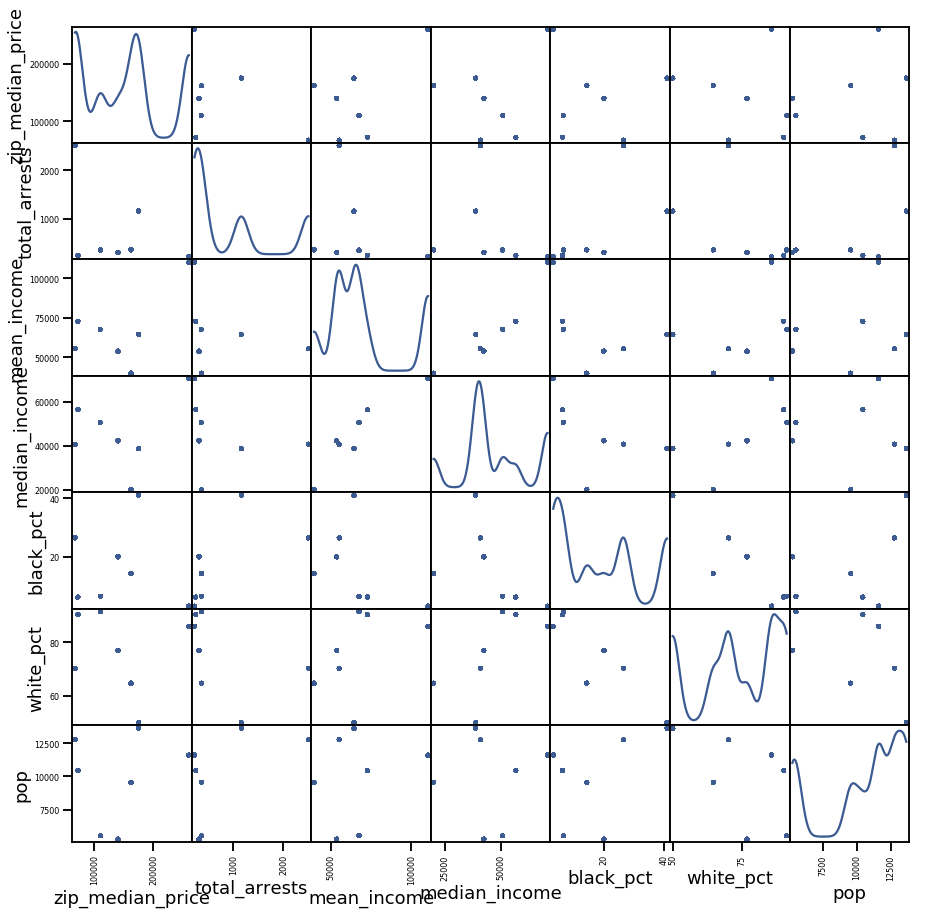

In [144]:
from pandas.plotting import scatter_matrix
sm = scatter_matrix(final_set[aggregate_attributes], figsize=(15, 15), diagonal='kde', alpha=.65)
#Change label rotation
# [s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
# [s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
# [s.get_yaxis().set_label_coords(-.7, 0.5) for s in sm.reshape(-1)]

# #Hide all ticks
# [s.set_xticks(()) for s in sm.reshape(-1)]
# [s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()